In [1]:
!nvidia-smi

Thu Mar  7 22:45:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Question 1
Implement and train your RNN language model on Wikitext-2 corpus using the
guidelines specified above.

a. provide a description (or illustration) of you architecture and discuss design choices,

b. list hyper-parameters used by you model and discuss how you selected these values,

c. provide learning curves of perplexity vs. epoch on the training and validation sets, and

d. provide final test set perplexity.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import itertools
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import multiprocessing as mp

TRAIN_PATH = 'wiki2.train.txt'
VALID_PATH = 'wiki2.valid.txt'
TEST_PATH = 'wiki2.test.txt'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# read files
with open(TRAIN_PATH, 'r') as file:
    content = file.read()
# split text
all_words = content.lower().split(' ')
# count the text frequency
word_f = Counter(all_words)

In [4]:
def plot_word_freq(word_freq_dict, word_freq_threshold):
    values = list(word_freq_dict.values())
    n, bins, patches = plt.hist(values, bins=10, range=(1, word_freq_threshold), edgecolor='black')
    for i in range(len(n)):
        plt.text(bins[i] + (bins[i+1] - bins[i])/2, n[i], str(int(n[i])), ha='center', va='bottom')
    plt.xticks(bins, rotation=45)
    plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in bins])
    plt.title('Histogram of Values from Dictionary')
    plt.xlabel('Word Frequency Range')
    plt.ylabel('Count of word frequencies')
    plt.show()

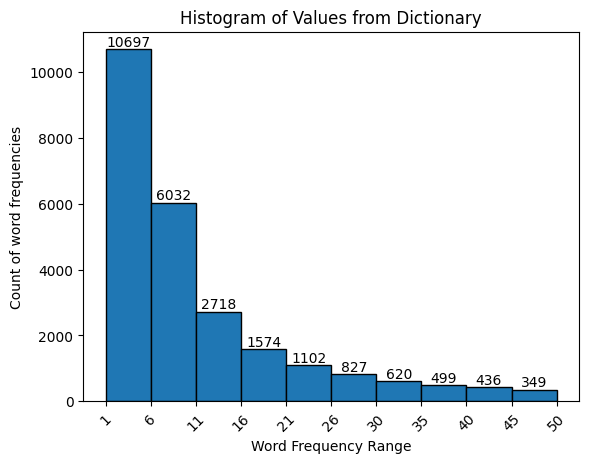

In [5]:
plot_word_freq(word_f, 50)

The above graph suggests that to reduce the Wikitext-2 vocabulary from approximately 33K to 10K, we should choose a word frequency of 15. Any word with a frequency lower than 15 should be set to 'unk'.

In [3]:
# Fix a seed for reproducibility
seed_value = 42
# PyTorch RNGs
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)

## Architecture and design

**Embedding Input**
Transforms token indices into embeddings, preparing them for sequence processing.

**RNN Processing**
Processes the embedded sequence through the RNN, updating the hidden state at each timestep.

**Output Handling**
The outputs are then reshaped for the fully connected layer to make token predictions. The outputs for the last timestep of each sequence are extracted using x[:, -1, :], indicating the model's prediction is based on the entire preceding sequence.

**Token Prediction**
Passes the last timestep's features through the fully connected layer to predict the next token.

In [15]:
class RNNModel(nn.Module):
    def __init__(self, params):
        super(RNNModel, self).__init__()
        self.params = params

        self.train_loader, self.valid_loader, self.test_loader, self.token_to_id = load_data(self.params)
        print (len(self.train_loader), len(self.valid_loader), len(self.test_loader))

        self.embedding = nn.Embedding(len(self.token_to_id), self.params['embedding_dim'])  # random initialize
        self.h = self._init_hidden(self.params['batch_size'])
        self.rnn = nn.RNN(self.params['embedding_dim'], self.params['hidden_dim'], self.params['num_rnn_layer'], dropout=self.params['dropout'], batch_first=True)
        self.fc = nn.Linear(self.params['hidden_dim'], len(self.token_to_id))

        self.criterion = nn.CrossEntropyLoss()
        if self.params['weight_decay']:
          self.optimizer = optim.Adam(self.parameters(), lr=self.params['learning_rate'], weight_decay=self.params['weight_decay'])
        else:
          self.optimizer = optim.Adam(self.parameters(), lr=self.params['learning_rate'])

    def _init_hidden(self, batch_size):
        return torch.zeros(self.params['num_rnn_layer'], batch_size, self.params['hidden_dim']).to(device)

    def forward(self, x, hidden):
        x = self.embedding(x)  # The embedding layer translates these indices into dense vectors of fixed size (the embedding size).
        x, hidden = self.rnn(x, hidden)
        if self.params['predict_next_token_after_seq']:
          x = x[:, -1, :]   # Select only the outputs from the last timestep of each sequence; we do not need this sentence if we predict the next token after each token within a sequence.
        x = x.contiguous().view(-1, self.params['hidden_dim'])  # Reshape output for the fully connected layer
        out = self.fc(x)
        return out, hidden

    def train(self):
        train_losses = []
        validation_losses = []
        train_perplexities = []
        validation_perplexities = []

        for epoch in range(self.params['epoch']):
            # Train
            train_loss = 0
            for id, (inputs, labels) in enumerate(self.train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()
                hidden = self._init_hidden(inputs.size(0))
                outputs, self.h = self.forward(inputs, hidden)
                self.h = self.h.detach().to(device)
                loss = self.criterion(outputs, labels.view(-1))
                loss.backward()
                if self.params['clip_value']:
                  torch.nn.utils.clip_grad_norm_(self.parameters(), self.params['clip_value'])
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(self.train_loader)
            train_losses.append(train_loss)
            train_perplexity = torch.exp(torch.tensor(train_loss)).item()
            train_perplexities.append(train_perplexity)

            # Validation
            validation_loss = 0
            with torch.no_grad():
                for id, (inputs, labels) in enumerate(self.valid_loader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    hidden = self._init_hidden(inputs.size(0))
                    outputs, _ = self.forward(inputs, hidden)
                    loss = self.criterion(outputs, labels.view(-1))
                    validation_loss += loss.item()
            validation_loss /= len(self.valid_loader)
            validation_losses.append(validation_loss)
            validation_perplexity = torch.exp(torch.tensor(validation_loss)).item()
            validation_perplexities.append(validation_perplexity)
            print (f'Epoch {epoch + 1}/{self.params["epoch"]}, Train Loss: {train_loss:.4f}, Train Perplexity: {train_perplexity:.4f}, Validation Loss: {validation_loss:.4f}, Validation Perplexity: {validation_perplexity:.4f}')

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        # Plotting Training and Validation Loss on the first subplot
        ax1.plot(train_losses, label='Training Loss', color='blue')
        ax1.plot(validation_losses, label='Validation Loss', color='red')
        ax1.set_title('Training and Validation Loss', fontsize=16)
        ax1.set_xlabel('Epochs', fontsize=14)
        ax1.set_ylabel('Loss', fontsize=14)
        ax1.legend()
        # Plotting Training and Validation Perplexity on the second subplot
        ax2.plot(train_perplexities, label='Training Perplexity', color='green')
        ax2.plot(validation_perplexities, label='Validation Perplexity', color='purple')
        ax2.set_title('Training and Validation Perplexity', fontsize=16)
        ax2.set_xlabel('Epochs', fontsize=14)
        ax2.set_ylabel('Perplexity', fontsize=14)
        ax2.legend()
        # Display the plots
        plt.tight_layout()
        # fig_name = '_'.join([str(item) for item in self.params.values()]) + '.jpg'
        # plt.savefig(fig_name, dpi=300, bbox_inches='tight')
        plt.show()

    def test(self):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                hidden = self._init_hidden(inputs.size(0))
                outputs, _ = self.forward(inputs, hidden)
                loss = self.criterion(outputs, labels.view(-1))
                total_loss += loss.item()
        avg_loss = total_loss / len(self.test_loader)
        perplexity = torch.exp(torch.tensor(avg_loss))
        print(f'Test Perplexity: {perplexity.item():.3f}')
        return avg_loss, perplexity

In [5]:
def replace_unk(original_dict, word_freq_threshold):
    new_dict = {}
    sum_values = 0
    words_replaced_w_unk = []
    for key, value in original_dict.items():
        if value < word_freq_threshold and key != '<unk>':
            sum_values += value
            words_replaced_w_unk.append(key)
        else:
            new_dict[key] = value
    if sum_values > 0:
        new_dict['<unk>'] = new_dict['<unk>'] + sum_values
    return new_dict, words_replaced_w_unk

In [6]:
def read_train_data(file_name):
    # Read files
    with open(file_name, 'r') as file:
        content = file.read()
    # Split text
    words = content.lower().split(' ')
    # Count the text frequency
    word_freq = Counter(words)
    # Replace keys with small frequencies with <unk>
    new_word_freq, words_replaced_w_unk = replace_unk(word_freq, 15)
    # Convert tokens to id
    token_to_id = {"<unk>": 0}
    token_to_id.update({word: idx for idx, word in enumerate(set([word for word in new_word_freq if word != '<unk>']), start=1)})
    # Convert corpus to id sequences
    sequences = [token_to_id.get(word, token_to_id["<unk>"]) for word in words]
    return sequences, token_to_id

In [7]:
def read_valid_test_data(file_name, token_to_id):
    # Read files
    with open(file_name, 'r') as file:
        content = file.read()
    # Split text
    words = content.lower().split(' ')
    # Convert corpus to id sequences
    sequences = [token_to_id.get(word, token_to_id["<unk>"]) for word in words]
    return sequences

In [19]:
class CustomDataset(Dataset):
    def __init__(self, text, params):
        self.data = [text[i:i + params['time_step']] for i in range(0, len(text) - params['time_step'])]
        if params['predict_next_token_after_seq']:
          self.labels = [text[i + params['time_step']] for i in range(0, len(text) - params['time_step'])]  # Predict the next token after a sequence
        else:
          self.labels = [text[i + 1:i + 1 + params['time_step']] for i in range(0, len(text) - params['time_step'])] # Predict the next token after each token within a sequence

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [17]:
def load_data(params):
    # Read data into id sequences
    train_data, token_to_id = read_train_data(TRAIN_PATH)
    valid_data = read_valid_test_data(VALID_PATH, token_to_id)
    test_data = read_valid_test_data(TEST_PATH, token_to_id)

    # Create dataset instances
    train_dataset = CustomDataset(train_data, params)
    valid_dataset = CustomDataset(valid_data, params)
    test_dataset = CustomDataset(test_data, params)

    # Load dataset
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=mp.cpu_count(), pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=mp.cpu_count(), pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=mp.cpu_count(), pin_memory=True)
    return train_loader, valid_loader, test_loader, token_to_id

## Hyper parameter

### Fixed parameters

**batch_size**: 1024

A trade-off between training speed and training resources, we pick 1024 as batch_size.

**epoch**: 20

It is required we train 20 epochs.

**num_rnn_layer**: 1

For question 1, we start with 1 rnn layer and will experiment with 2 or more layers in question 2.

**dropout**: 0,

Dropout is designed to prevent overfitting between the different layers of the network. It should only be applied when there are multiple layers (num_layers > 1) because it's meant to act between these layers. If we only have one layer (num_layers=1), there's nowhere for the dropout to be applied in the way it's intended in these models.

**weight_decay**: False

For question 1, we do not add weight decay for now as we do not know whether the language model is prone to overfitting yet. We will experiment with weight deday in question 2.

**clip_value**: False

For question 1, we do not add gradient clipping for now as we have not observed vanishing or exploding gradient yet. We will experiment with gradient clipping in question 2.


### More experiments

**predict_next_token_after_seq**: 1) predict the next token after each token within the sequence; 2) predict the next token after a whole sequence: baseline: 1), experiment:2)

**time_step**: baseline: 10, experiment: (10, 20, 30)

**embedding_dim**: baseline: 100, experiment: (100, 300)

**hidden_dim**: baseline: 100, experiment: (100, 200, 500)

**learning_rate**: baseline: 0.001, experiment: (0.001, 0.01)

Since we have limited computing resources, we will not run grid_search. Instead, we will compare paramters separately.

In [ ]:
def grid_search():
    params = {
        'batch_size': None,
        'time_step': None,
        'embedding_dim': None,
        'hidden_dim': None,
        'num_rnn_layer': None,
        'dropout': None,
        'epoch': None,
        'learning_rate': None,
        'weight_decay': None,
        'clip_value': None,}
    batch_size = [1024]
    time_step = [10, 20, 30]
    embedding_dim = [100, 300]
    hidden_dim = [100, 200, 500]
    num_rnn_layer = [1]
    dropout = [0]
    epoch = [20]
    learning_rate = [0.0001, 0.001]
    weight_decay = [False]
    clip_value = [False]
    param_combinations = list(itertools.product(batch_size, time_step, embedding_dim, hidden_dim, num_rnn_layer, dropout, epoch, learning_rate, weight_decay, clip_value))
    grid_search_data = []
    for combo in param_combinations:
        keys = list(params.keys())
        params_update = dict(zip(keys, combo))
        params.update(params_update)
        model = RNNModel(params).to(device)
        model.train()
        _, params['perplexity'] = model.test()
        print (params)
        grid_search_data.append(params.copy())
    df = pd.DataFrame(grid_search_data)
    df.to_csv('grid_search.csv', index=True)
    return df

## Baseline

We start with this initial parameters and further start experiments.

In [11]:
params = {
    'batch_size': 1024,
    'time_step': 10,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'weight_decay': False,
    'clip_value': False,
    'predict_next_token_after_seq': False
}

In [13]:
model = RNNModel(params)
model.to(device)

2039 213 240


RNNModel(
  (embedding): Embedding(9881, 100)
  (rnn): RNN(100, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=9881, bias=True)
  (criterion): CrossEntropyLoss()
)

Epoch 1/20, Train Loss: 5.3615, Train Perplexity: 213.0477
Epoch 1/20, Validation Loss: 4.9970, Validation Perplexity: 147.9617
Epoch 2/20, Train Loss: 4.7872, Train Perplexity: 119.9616
Epoch 2/20, Validation Loss: 4.8952, Validation Perplexity: 133.6409
Epoch 3/20, Train Loss: 4.6164, Train Perplexity: 101.1325
Epoch 3/20, Validation Loss: 4.8649, Validation Perplexity: 129.6576
Epoch 4/20, Train Loss: 4.5165, Train Perplexity: 91.5107
Epoch 4/20, Validation Loss: 4.8609, Validation Perplexity: 129.1439
Epoch 5/20, Train Loss: 4.4493, Train Perplexity: 85.5676
Epoch 5/20, Validation Loss: 4.8638, Validation Perplexity: 129.5175
Epoch 6/20, Train Loss: 4.4003, Train Perplexity: 81.4722
Epoch 6/20, Validation Loss: 4.8715, Validation Perplexity: 130.5164
Epoch 7/20, Train Loss: 4.3623, Train Perplexity: 78.4372
Epoch 7/20, Validation Loss: 4.8784, Validation Perplexity: 131.4221
Epoch 8/20, Train Loss: 4.3319, Train Perplexity: 76.0856
Epoch 8/20, Validation Loss: 4.8892, Validation Pe

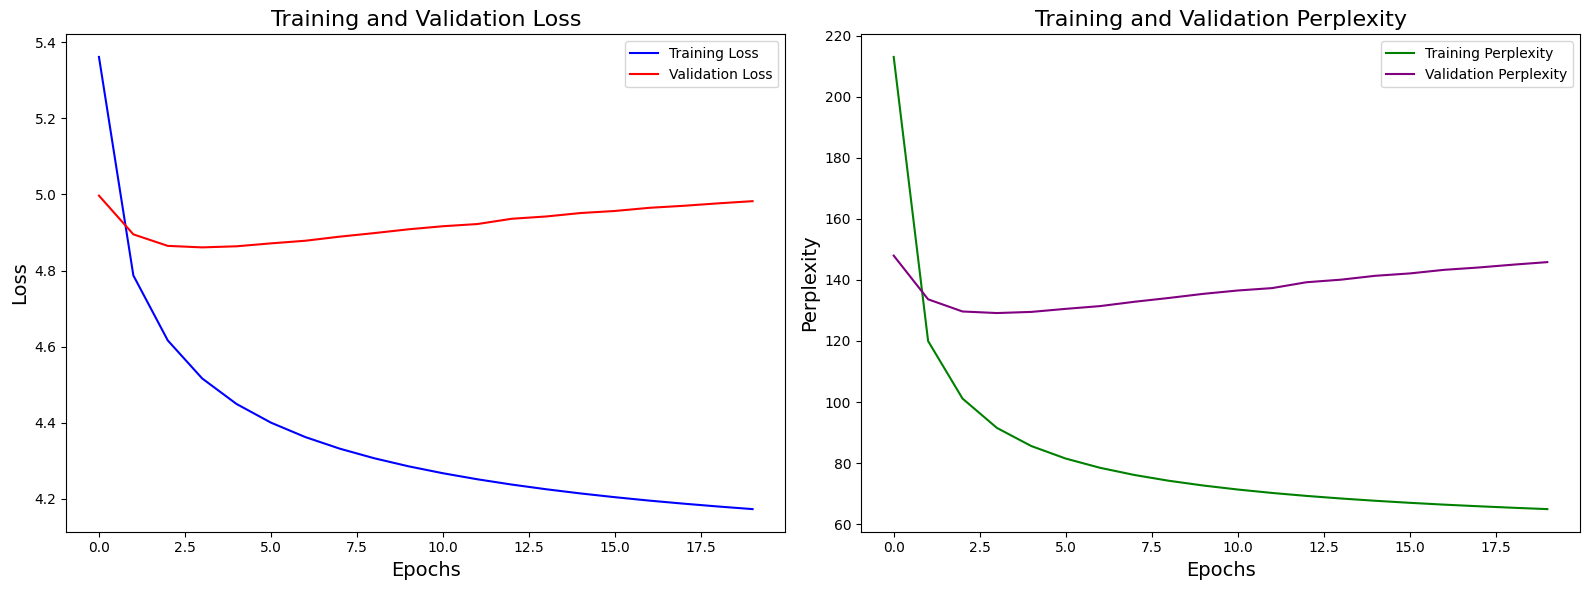

Test Perplexity: 136.269


(4.914629648129146, tensor(136.2688))

In [14]:
model.train()
model.test()

## Predict the next token after the sequence

We designed two ways of passing data into RNN.

1) predict the next token after each token within the sequence

2) predict the next token after a whole sequence

Since our baseline uses 1), we will experiment with 2) approach.

2039 213 240
Epoch 1/20, Train Loss: 5.6042, Train Perplexity: 271.5615, Validation Loss: 5.1485, Validation Perplexity: 172.1796
Epoch 2/20, Train Loss: 5.0747, Train Perplexity: 159.9291, Validation Loss: 4.9797, Validation Perplexity: 145.4360
Epoch 3/20, Train Loss: 4.8953, Train Perplexity: 133.6648, Validation Loss: 4.9033, Validation Perplexity: 134.7357
Epoch 4/20, Train Loss: 4.7836, Train Perplexity: 119.5331, Validation Loss: 4.8692, Validation Perplexity: 130.2162
Epoch 5/20, Train Loss: 4.7023, Train Perplexity: 110.1975, Validation Loss: 4.8350, Validation Perplexity: 125.8440
Epoch 6/20, Train Loss: 4.6375, Train Perplexity: 103.2854, Validation Loss: 4.8210, Validation Perplexity: 124.0836
Epoch 7/20, Train Loss: 4.5841, Train Perplexity: 97.9125, Validation Loss: 4.8076, Validation Perplexity: 122.4351
Epoch 8/20, Train Loss: 4.5388, Train Perplexity: 93.5758, Validation Loss: 4.8027, Validation Perplexity: 121.8448
Epoch 9/20, Train Loss: 4.5001, Train Perplexity: 90.

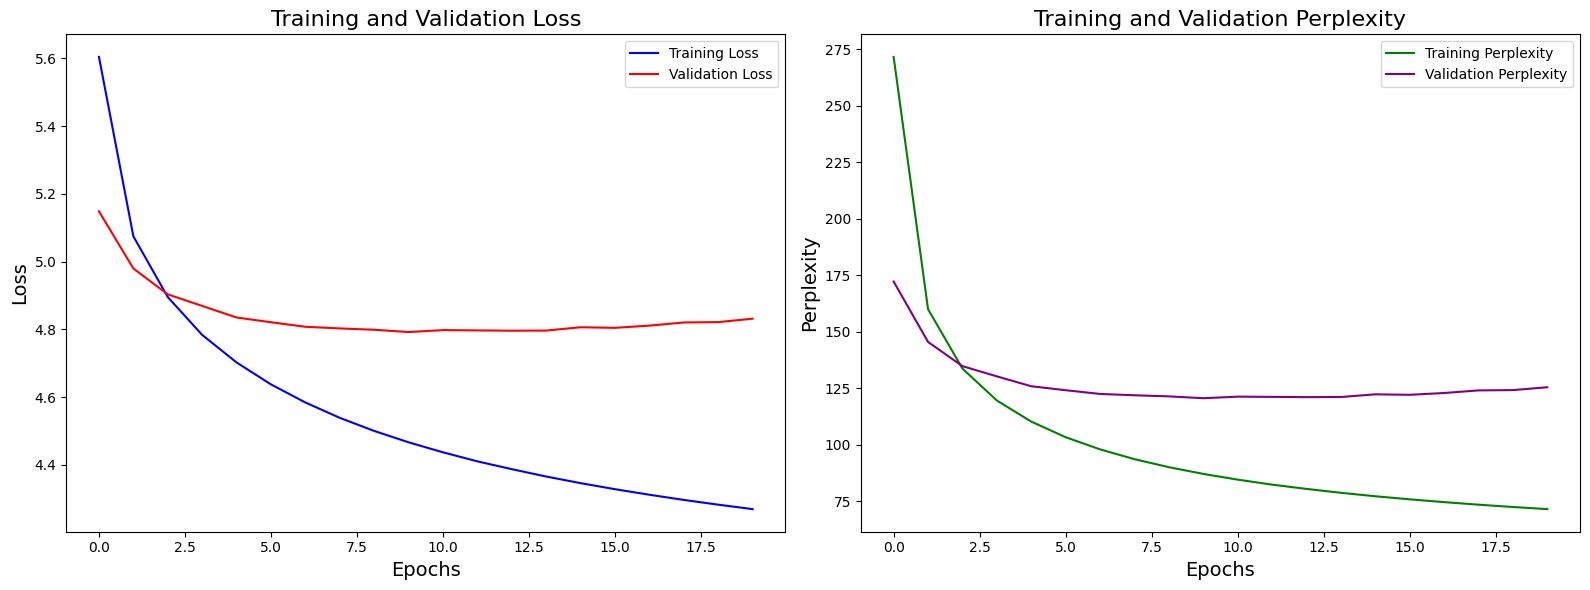

Test Perplexity: 116.279


(4.755994604031245, tensor(116.2793))

In [20]:
# predict_next_token_after_seq=True
params = {
    'time_step': 10,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'learning_rate': 0.001,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False,
    'predict_next_token_after_seq': True
}
model = RNNModel(params)
model.to(device)
model.train()
model.test()

As we can see from the results above

1) predict next token after each token within the sequence

2) predict next token after a whole sequence

Corresponding perplexity: 1) 136; 2) 116

**Observation:**
The second approach is better than 1). The reasons might be follows:
1. Method 2 allows the RNN to examine the entire sequence before making a prediction for the next token. This could mean that the network has a better overall understanding of the context and semantics of the sequence, leading to more informed and accurate predictions. In contrast, method 1 bases each prediction only on the context available up to the current token, which may not provide a complete picture.
2. In method 1, errors made in early predictions could propagate and affect subsequent predictions within the same sequence. In contrast, method 2 only makes one prediction per sequence, so there's no accumulation of prediction errors from earlier tokens within the same sequence.

**Conclusion:**
We will use second approach - predicting the next token after the sequence.

We will also use this param combination for our baseline for Question 1.

## Time step

As we can pick time step ranging from 10 to 30. We will do experiments on three values (10, 20, 30) to see the difference.

###Candidates:
10, 20, 30

We increase time step from 10 to 20 and 30.


2039 213 240
Epoch 1/20, Train Loss: 5.7257, Train Perplexity: 306.6554, Validation Loss: 5.2206, Validation Perplexity: 185.0366
Epoch 2/20, Train Loss: 5.1477, Train Perplexity: 172.0279, Validation Loss: 5.0078, Validation Perplexity: 149.5734
Epoch 3/20, Train Loss: 4.9295, Train Perplexity: 138.3161, Validation Loss: 4.9036, Validation Perplexity: 134.7802
Epoch 4/20, Train Loss: 4.7913, Train Perplexity: 120.4625, Validation Loss: 4.8551, Validation Perplexity: 128.3891
Epoch 5/20, Train Loss: 4.6909, Train Perplexity: 108.9486, Validation Loss: 4.8096, Validation Perplexity: 122.6876
Epoch 6/20, Train Loss: 4.6164, Train Perplexity: 101.1315, Validation Loss: 4.7851, Validation Perplexity: 119.7091
Epoch 7/20, Train Loss: 4.5571, Train Perplexity: 95.3108, Validation Loss: 4.7682, Validation Perplexity: 117.7090
Epoch 8/20, Train Loss: 4.5087, Train Perplexity: 90.8072, Validation Loss: 4.7607, Validation Perplexity: 116.8322
Epoch 9/20, Train Loss: 4.4678, Train Perplexity: 87.

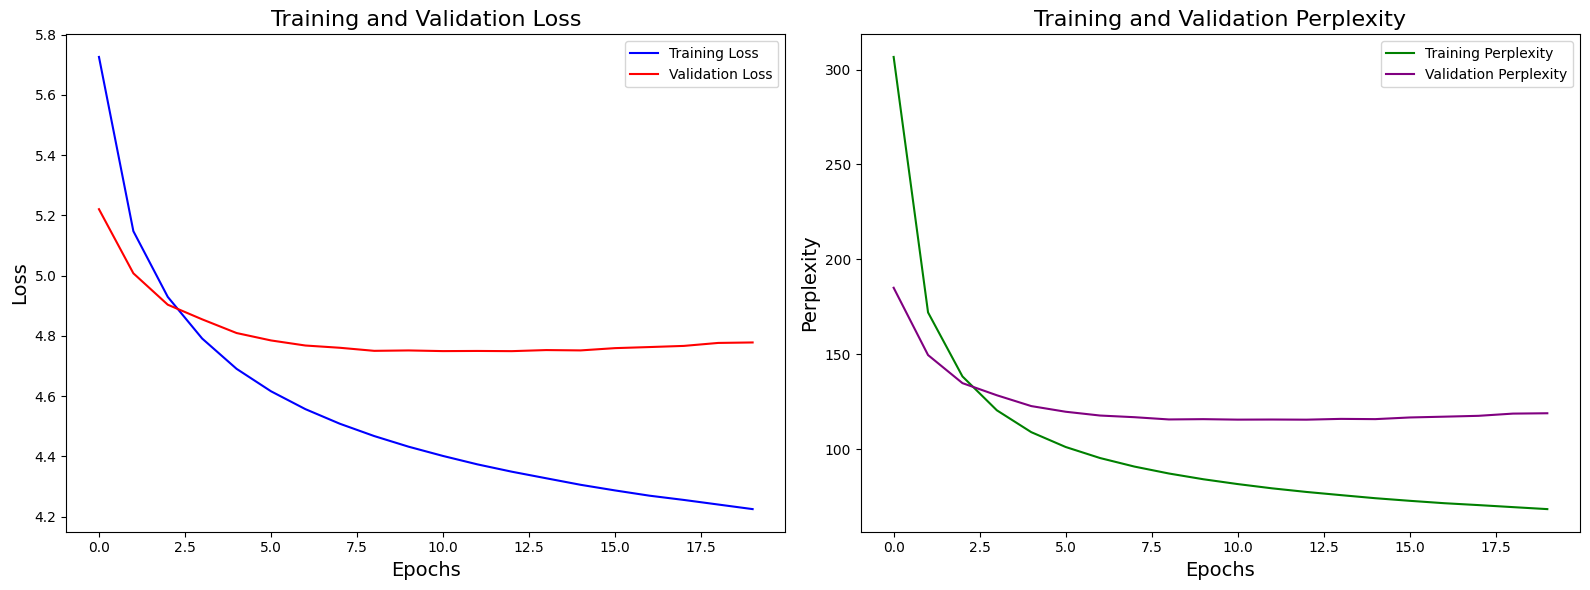

Test Perplexity: 110.384


(4.703966742753982, tensor(110.3842))

In [21]:
# time step = 20
params = {
    'time_step': 20,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'learning_rate': 0.001,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False,
    'predict_next_token_after_seq': True
}
model = RNNModel(params)
model.to(device)
model.train()
model.test()

2039 213 240
Epoch 1/20, Train Loss: 5.7916, Train Perplexity: 327.5355, Validation Loss: 5.3292, Validation Perplexity: 206.2639
Epoch 2/20, Train Loss: 5.2681, Train Perplexity: 194.0521, Validation Loss: 5.1054, Validation Perplexity: 164.9162
Epoch 3/20, Train Loss: 5.0479, Train Perplexity: 155.6966, Validation Loss: 4.9822, Validation Perplexity: 145.7880
Epoch 4/20, Train Loss: 4.8964, Train Perplexity: 133.8027, Validation Loss: 4.9122, Validation Perplexity: 135.9428
Epoch 5/20, Train Loss: 4.7836, Train Perplexity: 119.5309, Validation Loss: 4.8492, Validation Perplexity: 127.6392
Epoch 6/20, Train Loss: 4.6899, Train Perplexity: 108.8424, Validation Loss: 4.8078, Validation Perplexity: 122.4665
Epoch 7/20, Train Loss: 4.6117, Train Perplexity: 100.6561, Validation Loss: 4.7814, Validation Perplexity: 119.2717
Epoch 8/20, Train Loss: 4.5499, Train Perplexity: 94.6242, Validation Loss: 4.7541, Validation Perplexity: 116.0571
Epoch 9/20, Train Loss: 4.4998, Train Perplexity: 90

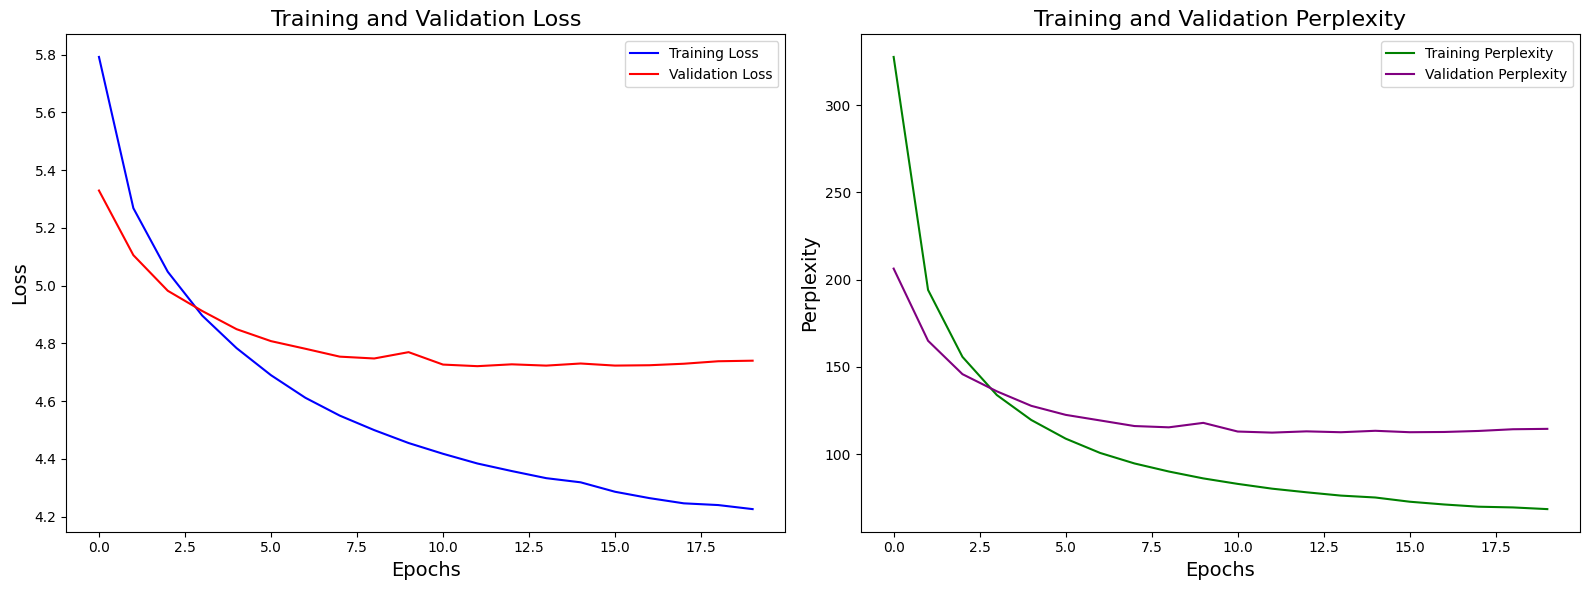

Test Perplexity: 106.545


(4.668564186493556, tensor(106.5447))

In [23]:
# time step = 30
params = {
    'time_step': 30,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'learning_rate': 0.001,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False,
    'predict_next_token_after_seq': True
}
model = RNNModel(params).to(device)
model.train()
model.test()

As we can see from the results above,

Time step: 10, 20, 30

Corresponding perplexity: 116, 110, 106

**Observation:**

In the range of (10,30), longer time steps enable the model to learn better.

**Conclusion:**

We will use time_step=30

## The size of word embedding
Common dimensions for word embeddings include below. The choice of dimensionality depends on the specific network, the size and complexity of the dataset, and the computational resources available. Higher dimensions can capture more detailed semantics but require more computational power and data to train effectively. Since we should start from 100 dimensions and we do not have a complex network like transformer, we pick 100 and 300 to experiment.

- 50 dimensions: Often used for smaller datasets where the linguistic complexity is lower. This smaller dimension can capture basic semantic relationships with less computational cost.
- 100 dimensions: This is a middle-ground choice, balancing between capturing sufficient semantic detail and maintaining manageable computational requirements.
- 300 dimensions: This is one of the most common dimensions used, especially in models like Word2Vec or GloVe trained on large text corpora. It offers a good balance between detailed semantic capture and computational efficiency.
- 768 dimensions: Embeddings like those from BERT (a transformer-based model) use this size, offering very detailed representations of word meanings based on broader contexts.
- 1024 dimensions and beyond: Used in even larger and more complex models such as GPT-3 and newer versions of BERT, these higher-dimensional embeddings can capture nuanced meanings and relationships but at the cost of increased computational resources.


### Candidates:
100, 300

We increase word embedding size from 100 to 300.


2039 213 240
Epoch 1/20, Train Loss: 5.5429, Train Perplexity: 255.4182, Validation Loss: 5.0930, Validation Perplexity: 162.8777
Epoch 2/20, Train Loss: 5.0081, Train Perplexity: 149.6135, Validation Loss: 4.9353, Validation Perplexity: 139.1207
Epoch 3/20, Train Loss: 4.8294, Train Perplexity: 125.1340, Validation Loss: 4.8728, Validation Perplexity: 130.6857
Epoch 4/20, Train Loss: 4.7179, Train Perplexity: 111.9297, Validation Loss: 4.8381, Validation Perplexity: 126.2315
Epoch 5/20, Train Loss: 4.6374, Train Perplexity: 103.2766, Validation Loss: 4.8167, Validation Perplexity: 123.5588
Epoch 6/20, Train Loss: 4.5756, Train Perplexity: 97.0848, Validation Loss: 4.8128, Validation Perplexity: 123.0807
Epoch 7/20, Train Loss: 4.5255, Train Perplexity: 92.3439, Validation Loss: 4.8039, Validation Perplexity: 121.9802
Epoch 8/20, Train Loss: 4.4835, Train Perplexity: 88.5457, Validation Loss: 4.8022, Validation Perplexity: 121.7757
Epoch 9/20, Train Loss: 4.4479, Train Perplexity: 85.4

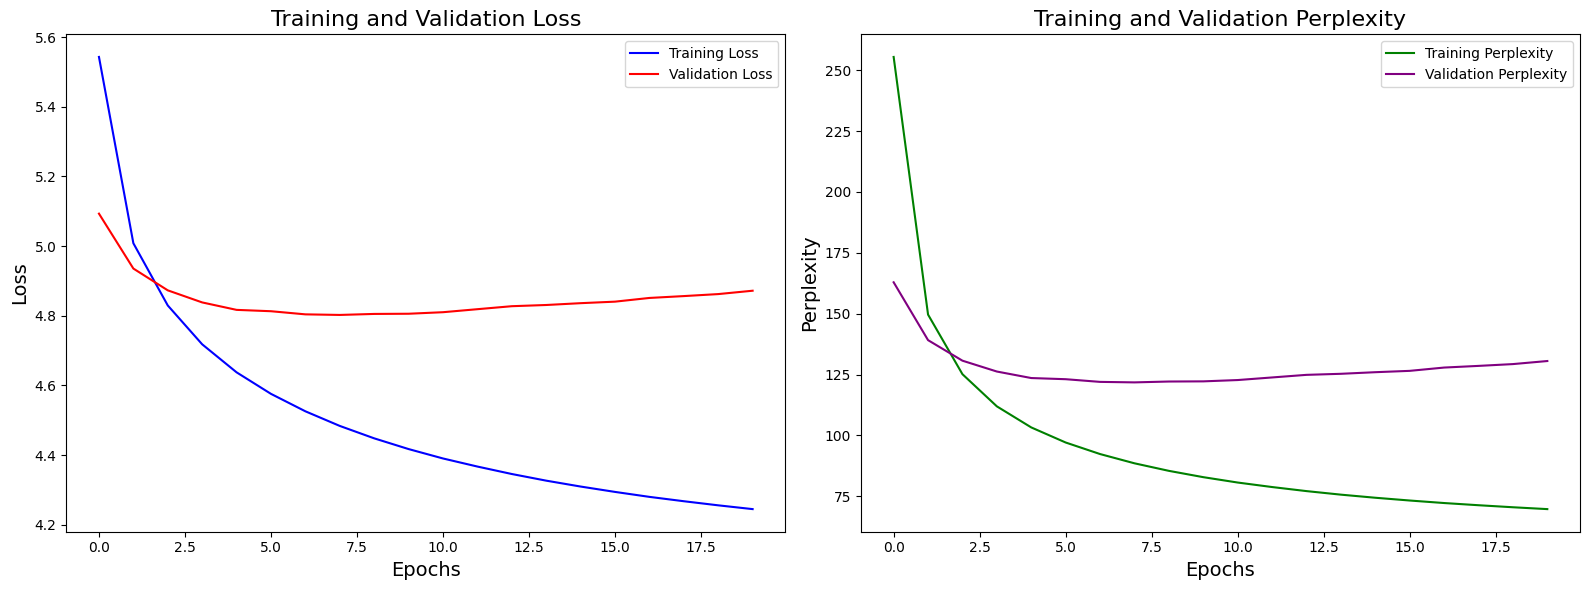

Test Perplexity: 122.156


(4.805296450853348, tensor(122.1557))

In [25]:
# embedding_dim = 300
params = {
    'embedding_dim': 300,
    'time_step': 10,
    'hidden_dim': 100,
    'learning_rate': 0.001,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False,
    'predict_next_token_after_seq': True
}
model = RNNModel(params).to(device)
model.train()
model.test()

As we can see from the results above,

word embedding size: 100, 300

Corresponding perplexity: 116, 122

**Observation:**

The performance degrades after we increase the size of word embedding. The reasons might be follows:

1. The model already encounters overfitting problem. Increasing the size of the word embeddings increases the dimensionality of the input data and number of paramters, which can exacerbate overfitting.
2. Our dataset is not large enough to support learning such a high-dimensional representation. If the training data is limited, the model may learn to memorize the training set rather than generalizing from it.

**Conclusion:**

We will use embedding_dim=100

## The size of hidden state

The hidden state size does not have to be equal to the input size.
The hidden state size in RNNs determines the capacity of the network to capture information from past inputs. There is no one-size-fits-all answer, but here are common practices:

- Small Datasets and Simpler Problems: Typically consists of a few hundred to a few thousand samples. Hidden state sizes can range from 50 to 200 units. Smaller hidden states reduce the risk of overfitting on limited data.
- Medium to Large Datasets: Count: Ranges from tens of thousands to a few hundred thousand samples. For tabular data, this might be between 10,000 and 500,000 records. Hidden state sizes can range from 200 to 600 units. Larger hidden states can capture more information and nuances from the input sequences.
- Very Complex Tasks: In tasks like large-scale language modeling or sequence-to-sequence models, hidden state sizes can be even larger, ranging from 600 to 2000 units or more, depending on computational resources and the specific requirements of the task.

### Candidates

100, 200

We increase hidden state size from 100 to 200.

2039 213 240
Epoch 1/20, Train Loss: 5.4741, Train Perplexity: 238.4338, Validation Loss: 5.0306, Validation Perplexity: 153.0303
Epoch 2/20, Train Loss: 4.9155, Train Perplexity: 136.3828, Validation Loss: 4.8693, Validation Perplexity: 130.2247
Epoch 3/20, Train Loss: 4.6985, Train Perplexity: 109.7798, Validation Loss: 4.8077, Validation Perplexity: 122.4478
Epoch 4/20, Train Loss: 4.5611, Train Perplexity: 95.6842, Validation Loss: 4.7815, Validation Perplexity: 119.2830
Epoch 5/20, Train Loss: 4.4623, Train Perplexity: 86.6892, Validation Loss: 4.7659, Validation Perplexity: 117.4356
Epoch 6/20, Train Loss: 4.3849, Train Perplexity: 80.2302, Validation Loss: 4.7585, Validation Perplexity: 116.5762
Epoch 7/20, Train Loss: 4.3212, Train Perplexity: 75.2767, Validation Loss: 4.7621, Validation Perplexity: 116.9947
Epoch 8/20, Train Loss: 4.2668, Train Perplexity: 71.2911, Validation Loss: 4.7672, Validation Perplexity: 117.5907
Epoch 9/20, Train Loss: 4.2196, Train Perplexity: 68.006

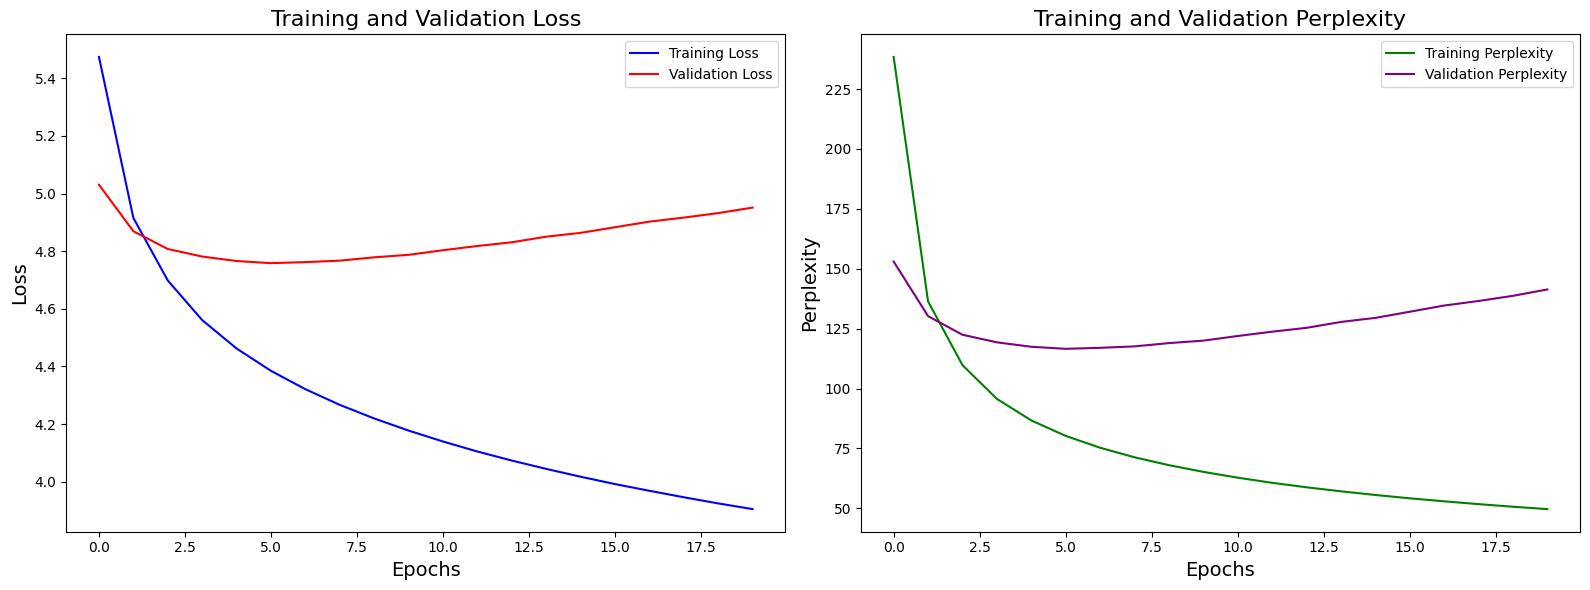

Test Perplexity: 132.451


(4.886215401689212, tensor(132.4513))

In [26]:
# hidden_dim = 200
params = {
    'hidden_dim': 200,
    'embedding_dim': 100,
    'time_step': 10,
    'learning_rate': 0.001,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False,
    'predict_next_token_after_seq': True
}
model = RNNModel(params).to(device)
model.train()
model.test()

As we can see from the results above,

hidden state size: 100, 200

Corresponding perplexity: 116, 132

**Observation:**

The performance of my rnn model degrades after we increase the size of hidden state from 100 to 200.
1. Increasing the size of the hidden state increases the complexity of the RNN model. A larger hidden state means the model has more parameters and thus a greater capacity to learn from the training data. While this can be beneficial for capturing more nuanced patterns and dependencies, it can also lead the model to learn irrelevant details and noise from the training data, leading to overfitting, especially our model already faces overfitting problem when hidden size=100.
2. Our dataset is not huge, a model with a large number of parameters (due to a large hidden state) is likely to overfit.

**Conclusion:**

We will use hidden_dim=100

## Learning Rate

A typical starting learning rate for RNNs can range from 0.001 to 0.01. This range is broad enough to encompass different scenarios from slow, careful learning to more aggressive updates.  We will do experiments on two values (0.001, 0.01) to see the difference.

### Candidates:
(0.001, 0.01)

We increase learning_rate from 0.001 to 0.01.

2039 213 240
Epoch 1/20, Train Loss: 5.4640, Train Perplexity: 236.0334, Validation Loss: 5.2218, Validation Perplexity: 185.2638
Epoch 2/20, Train Loss: 5.1823, Train Perplexity: 178.0943, Validation Loss: 5.2996, Validation Perplexity: 200.2495
Epoch 3/20, Train Loss: 5.2049, Train Perplexity: 182.1702, Validation Loss: 5.3360, Validation Perplexity: 207.6732
Epoch 4/20, Train Loss: 5.2583, Train Perplexity: 192.1486, Validation Loss: 5.3879, Validation Perplexity: 218.7340
Epoch 5/20, Train Loss: 5.3277, Train Perplexity: 205.9658, Validation Loss: 5.4193, Validation Perplexity: 225.7323
Epoch 6/20, Train Loss: 5.3616, Train Perplexity: 213.0700, Validation Loss: 5.4840, Validation Perplexity: 240.8007
Epoch 7/20, Train Loss: 5.4135, Train Perplexity: 224.4131, Validation Loss: 5.5083, Validation Perplexity: 246.7253
Epoch 8/20, Train Loss: 5.4297, Train Perplexity: 228.0772, Validation Loss: 5.5288, Validation Perplexity: 251.8470
Epoch 9/20, Train Loss: 5.4457, Train Perplexity: 2

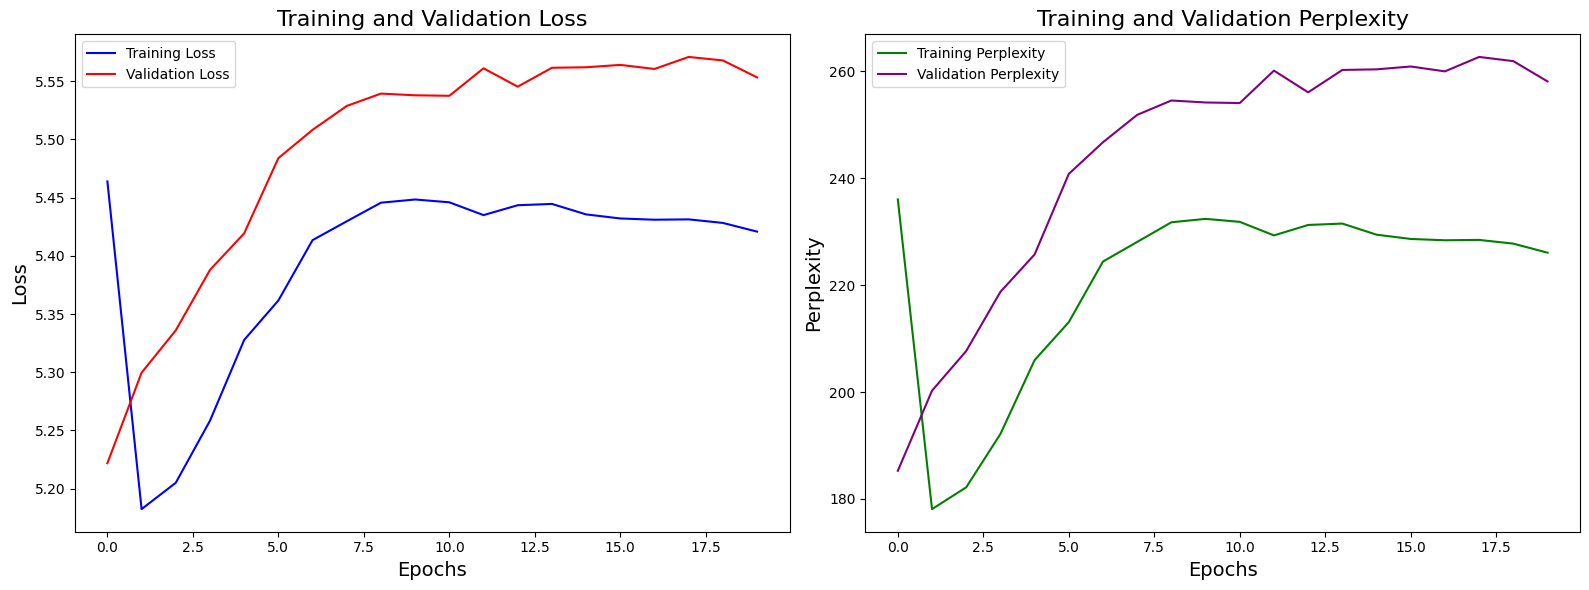

Test Perplexity: 238.893


(5.476013815402984, tensor(238.8925))

In [27]:
params = {
    'learning_rate': 0.01,
    'hidden_dim': 100,
    'embedding_dim': 100,
    'time_step': 10,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False,
    'predict_next_token_after_seq': True
}
model = RNNModel(params).to(device)
model.train()
model.test()

As we can see from the results above,

learning rate: 0.001, 0.01

Corresponding perplexity: 116, 238

**Observation:**
learning rate is too high. Although it learns fast at the beginning, the models steps over the optimum and loss further increases.

**Conclusion:**

We will use learning rate=0.001

## Best Parameter for Question 1

Below is the best hyper parameters for Question 1, and its perplexity is 109. This will serve as our baseline for Question 2 and 3.

2039 213 240
Epoch 1/20, Train Loss: 5.7422, Train Perplexity: 311.7376, Validation Loss: 5.2119, Validation Perplexity: 183.4361
Epoch 2/20, Train Loss: 5.1339, Train Perplexity: 169.6691, Validation Loss: 4.9918, Validation Perplexity: 147.1940
Epoch 3/20, Train Loss: 4.9165, Train Perplexity: 136.5201, Validation Loss: 4.8918, Validation Perplexity: 133.1868
Epoch 4/20, Train Loss: 4.7789, Train Perplexity: 118.9777, Validation Loss: 4.8374, Validation Perplexity: 126.1388
Epoch 5/20, Train Loss: 4.6819, Train Perplexity: 107.9804, Validation Loss: 4.8018, Validation Perplexity: 121.7313
Epoch 6/20, Train Loss: 4.6102, Train Perplexity: 100.5087, Validation Loss: 4.7778, Validation Perplexity: 118.8465
Epoch 7/20, Train Loss: 4.5531, Train Perplexity: 94.9251, Validation Loss: 4.7633, Validation Perplexity: 117.1281
Epoch 8/20, Train Loss: 4.5063, Train Perplexity: 90.5861, Validation Loss: 4.7515, Validation Perplexity: 115.7536
Epoch 9/20, Train Loss: 4.4675, Train Perplexity: 87.

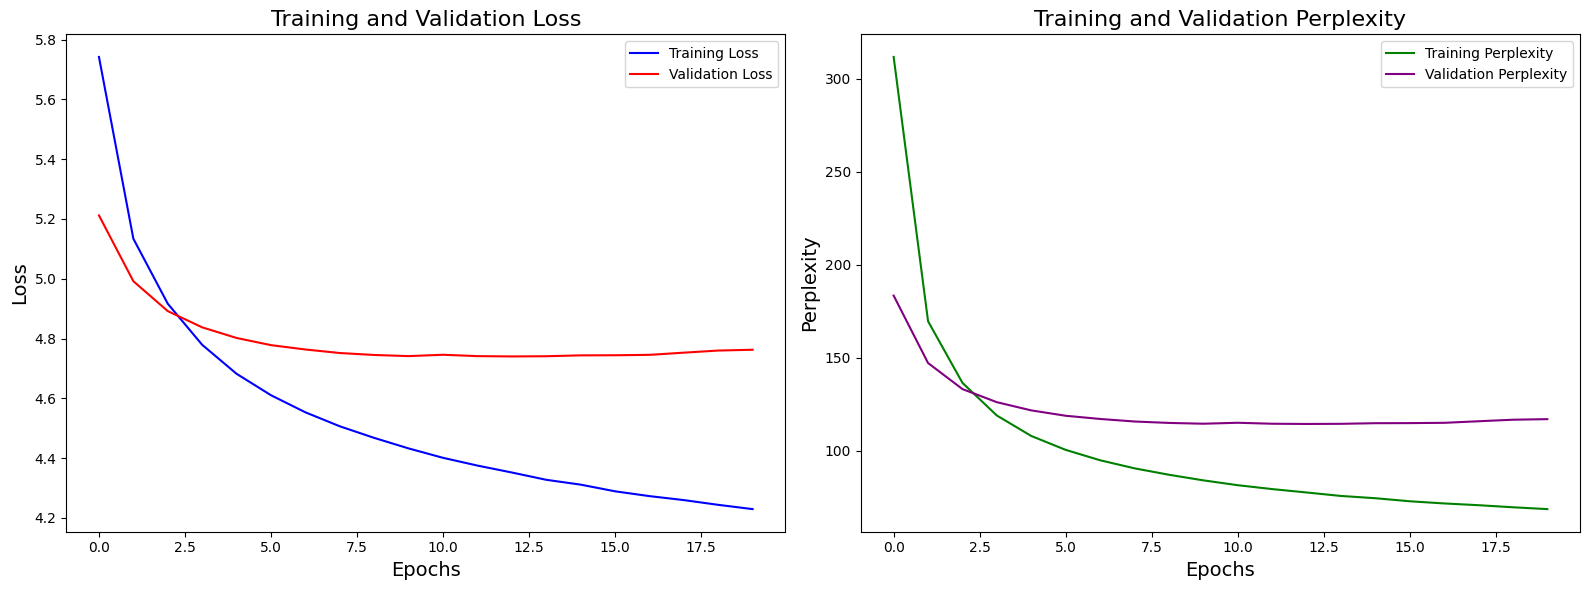

Test Perplexity: 109.006


(4.691402277350425, tensor(109.0059))

In [37]:
params = {
    'learning_rate': 0.001,
    'hidden_dim': 100,
    'embedding_dim': 100,
    'time_step': 30,
    'batch_size': 1024,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'weight_decay': False,
    'clip_value': False,
    'predict_next_token_after_seq': True
}
model = RNNModel(params).to(device)
model.train()
model.test()

# Question 2
Discuss how you might improve this “vanilla” RNN language modeling
architecture.

- **Regularization Techniques:**
    - **Weight Regularization**: Adding L1 or L2 regularization to the weights can also help in preventing overfitting.
      - As we can see from above, there is overfitting problem. We will use L2 weight decay to minimize the overfitting.
- **Optimization and Training Techniques:**
    - **Gradient Clipping**: This is crucial for preventing the exploding gradient problem in RNNs. It limits the size of the gradients during backpropagation to ensure stable training.
      - We will implement Gradient Clipping
- **Architectural Tweaks:**
    - **Stacked RNN Layers**: Increase the model's capacity by adding more layers. However, be mindful of the increased computational cost and the potential for overfitting.
      - We will use 2 layers to compare the result.
- **Advanced RNN Architectures:**
    - **LSTM and GRU**: Vanilla RNNs suffer from vanishing and exploding gradient problems, making them less effective for learning long-term dependencies. Long Short-Term Memory (LSTM) units or Gated Recurrent Units (GRU) are more sophisticated variants that can capture long-range dependencies better, improving the model's performance on tasks requiring understanding of longer context.
      - We will change the current structure to LSTM.
    - **Bidirectional RNNs**: These process the data in both forward and backward directions, providing a richer representation of the context which can improve the model's understanding and predictions.
- **Embedding Layer Improvements:**
    - **Pre-trained Word Embeddings**: Instead of learning word embeddings from scratch, use pre-trained embeddings like GloVe or Word2Vec. These can provide a good starting point and add external knowledge to your model.
      - Since it needs extra pretrained model here, we will not implement this one.

# Question 3
Implement one (or more) of the improvements mentioned above, and
provide a new set of learning curves and final test perplexity.

## 1. Add L2 weight decay

As we can see from above, there is overfitting problem. We will use L2 weight decay to tackle the problem.

Here, we use weight decay=0.0001

2039 213 240
Epoch 1/20, Train Loss: 5.6960, Train Perplexity: 297.6664, Validation Loss: 5.2266, Validation Perplexity: 186.1585
Epoch 2/20, Train Loss: 5.1901, Train Perplexity: 179.4931, Validation Loss: 5.0107, Validation Perplexity: 150.0112
Epoch 3/20, Train Loss: 5.0492, Train Perplexity: 155.8991, Validation Loss: 4.9395, Validation Perplexity: 139.7016
Epoch 4/20, Train Loss: 4.9763, Train Perplexity: 144.9390, Validation Loss: 4.8911, Validation Perplexity: 133.0983
Epoch 5/20, Train Loss: 4.9264, Train Perplexity: 137.8821, Validation Loss: 4.8615, Validation Perplexity: 129.2132
Epoch 6/20, Train Loss: 4.8934, Train Perplexity: 133.4055, Validation Loss: 4.8400, Validation Perplexity: 126.4690
Epoch 7/20, Train Loss: 4.8704, Train Perplexity: 130.3693, Validation Loss: 4.8272, Validation Perplexity: 124.8589
Epoch 8/20, Train Loss: 4.8526, Train Perplexity: 128.0676, Validation Loss: 4.8113, Validation Perplexity: 122.8948
Epoch 9/20, Train Loss: 4.8381, Train Perplexity: 1

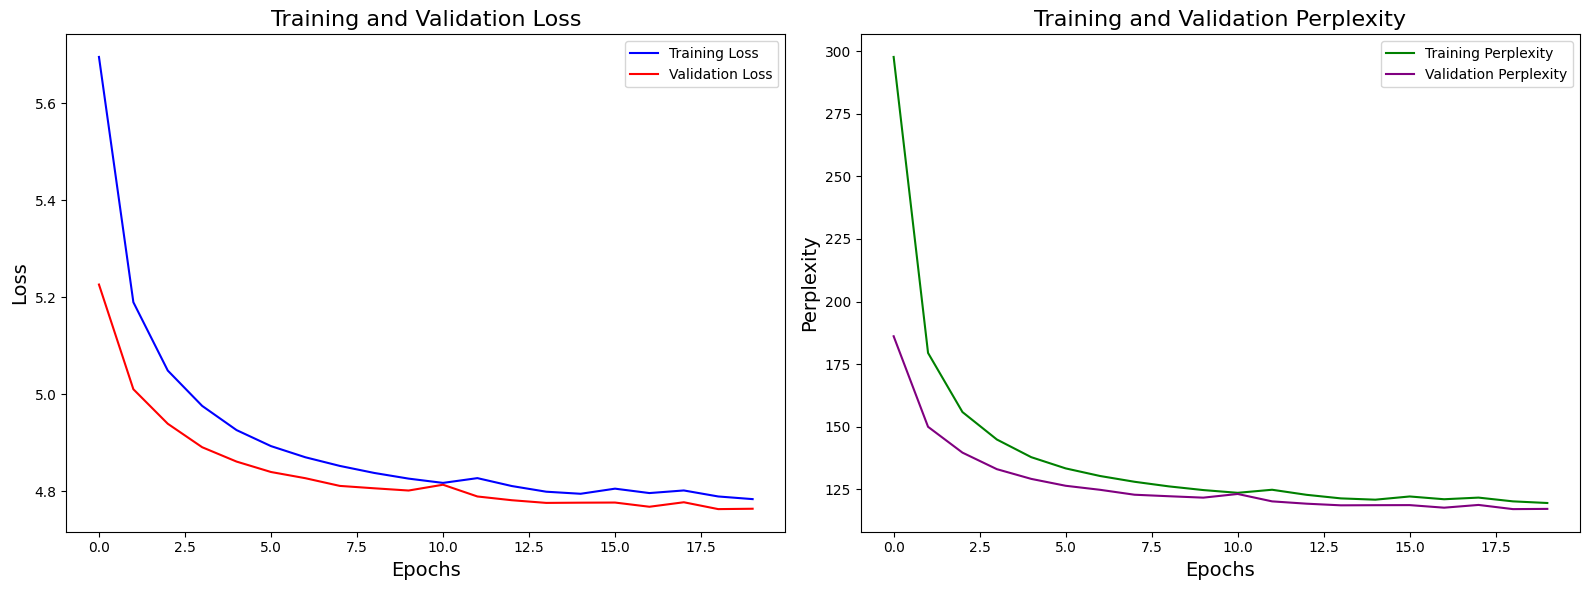

Test Perplexity: 109.069


(4.6919805943965915, tensor(109.0690))

In [28]:
params = {
    'batch_size': 1024,
    'time_step': 30,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'weight_decay': 0.0001,
    'clip_value': False,
    'predict_next_token_after_seq': True
}
model = RNNModel(params).to(device)
model.train()
model.test()

**Conclusion**

After we use L2 weight decay to minimize the overfitting, it significantly reduced the overfitting problem. However, the performance did not increase. Since we are required to train the model for 20 epochs, if we extend the training time, it's likely we can see more improvement.

## 2. Add Gradient Clipping

RNN is particularly prone to the exploding gradient problem due to their inherent structure and the way they learn temporal dependencies from data. This susceptibility is primarily due to the repeated multiplication of gradients through time during the backpropagation through time (BPTT) process, which is used to train RNNs. In RNNs, the hidden state at each timestep is a function of the previous hidden state and the current input. This recurrence relation means that the hidden state is effectively a product of all previous hidden states and inputs. During backpropagation, this leads to gradients being multiplied through each timestep.

Gradient Clipping limits the size of the gradients during backpropagation to ensure stable training.

Below are experiments with clip values of 1 and 5.

2039 213 240
Epoch 1/20, Train Loss: 5.6742, Train Perplexity: 291.2547, Validation Loss: 5.2045, Validation Perplexity: 182.0872
Epoch 2/20, Train Loss: 5.1887, Train Perplexity: 179.2326, Validation Loss: 5.0131, Validation Perplexity: 150.3698
Epoch 3/20, Train Loss: 5.0487, Train Perplexity: 155.8211, Validation Loss: 4.9344, Validation Perplexity: 138.9953
Epoch 4/20, Train Loss: 4.9742, Train Perplexity: 144.6389, Validation Loss: 4.8908, Validation Perplexity: 133.0638
Epoch 5/20, Train Loss: 4.9296, Train Perplexity: 138.3269, Validation Loss: 4.8634, Validation Perplexity: 129.4587
Epoch 6/20, Train Loss: 4.8998, Train Perplexity: 134.2694, Validation Loss: 4.8408, Validation Perplexity: 126.5736
Epoch 7/20, Train Loss: 4.8781, Train Perplexity: 131.3766, Validation Loss: 4.8341, Validation Perplexity: 125.7282
Epoch 8/20, Train Loss: 4.8612, Train Perplexity: 129.1800, Validation Loss: 4.8279, Validation Perplexity: 124.9477
Epoch 9/20, Train Loss: 4.8462, Train Perplexity: 1

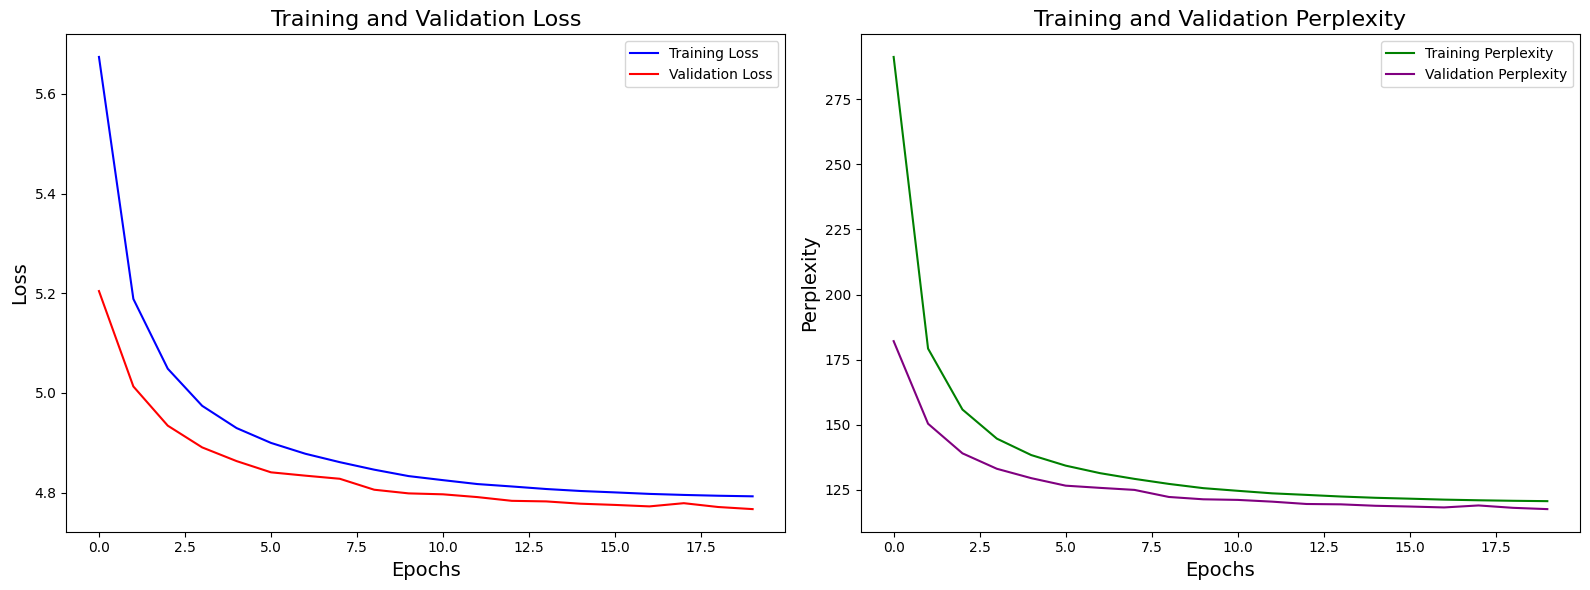

Test Perplexity: 109.417


(4.695170186956724, tensor(109.4174))

In [29]:
params = {
    'batch_size': 1024,
    'time_step': 30,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'weight_decay': 0.0001,
    'clip_value': 1,
    'predict_next_token_after_seq': True
}
model = RNNModel(params).to(device)
model.train()
model.test()

2039 213 240
Epoch 1/20, Train Loss: 5.7094, Train Perplexity: 301.6906, Validation Loss: 5.2300, Validation Perplexity: 186.7835
Epoch 2/20, Train Loss: 5.2071, Train Perplexity: 182.5596, Validation Loss: 5.0253, Validation Perplexity: 152.2164
Epoch 3/20, Train Loss: 5.0629, Train Perplexity: 158.0536, Validation Loss: 4.9541, Validation Perplexity: 141.7486
Epoch 4/20, Train Loss: 4.9885, Train Perplexity: 146.7167, Validation Loss: 4.9018, Validation Perplexity: 134.5281
Epoch 5/20, Train Loss: 4.9361, Train Perplexity: 139.2238, Validation Loss: 4.8702, Validation Perplexity: 130.3485
Epoch 6/20, Train Loss: 4.9023, Train Perplexity: 134.6006, Validation Loss: 4.8460, Validation Perplexity: 127.2287
Epoch 7/20, Train Loss: 4.8787, Train Perplexity: 131.4618, Validation Loss: 4.8331, Validation Perplexity: 125.6021
Epoch 8/20, Train Loss: 4.8603, Train Perplexity: 129.0566, Validation Loss: 4.8209, Validation Perplexity: 124.0731
Epoch 9/20, Train Loss: 4.8445, Train Perplexity: 1

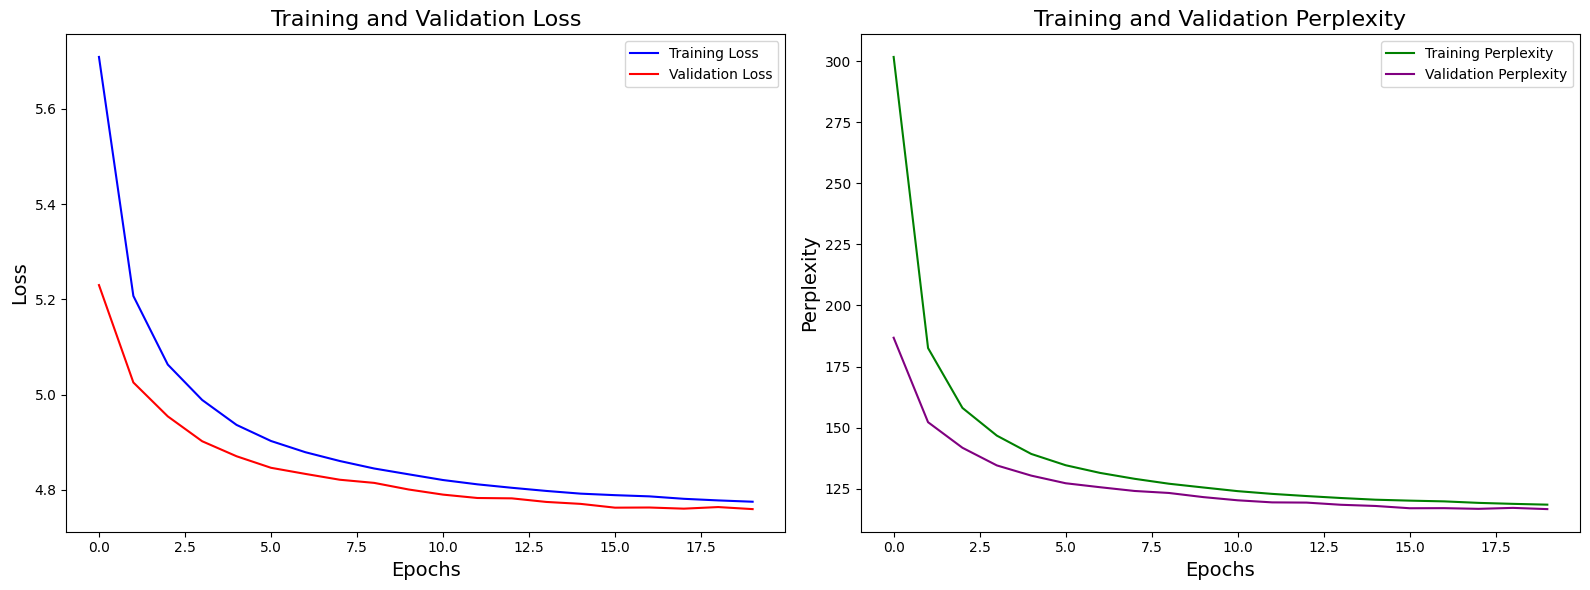

Test Perplexity: 108.848


(4.68995041847229, tensor(108.8478))

In [30]:
params = {
    'batch_size': 1024,
    'time_step': 30,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 1,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'weight_decay': 0.0001,
    'clip_value': 5,
    'predict_next_token_after_seq': True
}
model = RNNModel(params).to(device)
model.train()
model.test()

**Conclusion**

Since we have not met with exploding gradients so far, it is not that effective in increasing performance.

## 3. Add RNN layers
We want to increase the model's capacity by adding more layers. Here, we will increase from 1 RNN layer to 2 layers. However, we should be be mindful of the increased computational cost and the potential for overfitting. Therefore, we will try no dropout and with dropout.



### No dropout
rnn_layers=2, dropout=0

🌟🌟🌟 This is the best model we have achieved with perplexity of 105.

2039 213 240
Epoch 1/20, Train Loss: 5.6763, Train Perplexity: 291.8596, Validation Loss: 5.1772, Validation Perplexity: 177.1898
Epoch 2/20, Train Loss: 5.1417, Train Perplexity: 170.9986, Validation Loss: 4.9652, Validation Perplexity: 143.3397
Epoch 3/20, Train Loss: 4.9800, Train Perplexity: 145.4781, Validation Loss: 4.8732, Validation Perplexity: 130.7427
Epoch 4/20, Train Loss: 4.8913, Train Perplexity: 133.1212, Validation Loss: 4.8252, Validation Perplexity: 124.6084
Epoch 5/20, Train Loss: 4.8405, Train Perplexity: 126.5363, Validation Loss: 4.7868, Validation Perplexity: 119.9148
Epoch 6/20, Train Loss: 4.8063, Train Perplexity: 122.2833, Validation Loss: 4.7675, Validation Perplexity: 117.6208
Epoch 7/20, Train Loss: 4.7813, Train Perplexity: 119.2629, Validation Loss: 4.7590, Validation Perplexity: 116.6257
Epoch 8/20, Train Loss: 4.7634, Train Perplexity: 117.1434, Validation Loss: 4.7487, Validation Perplexity: 115.4355
Epoch 9/20, Train Loss: 4.7482, Train Perplexity: 1

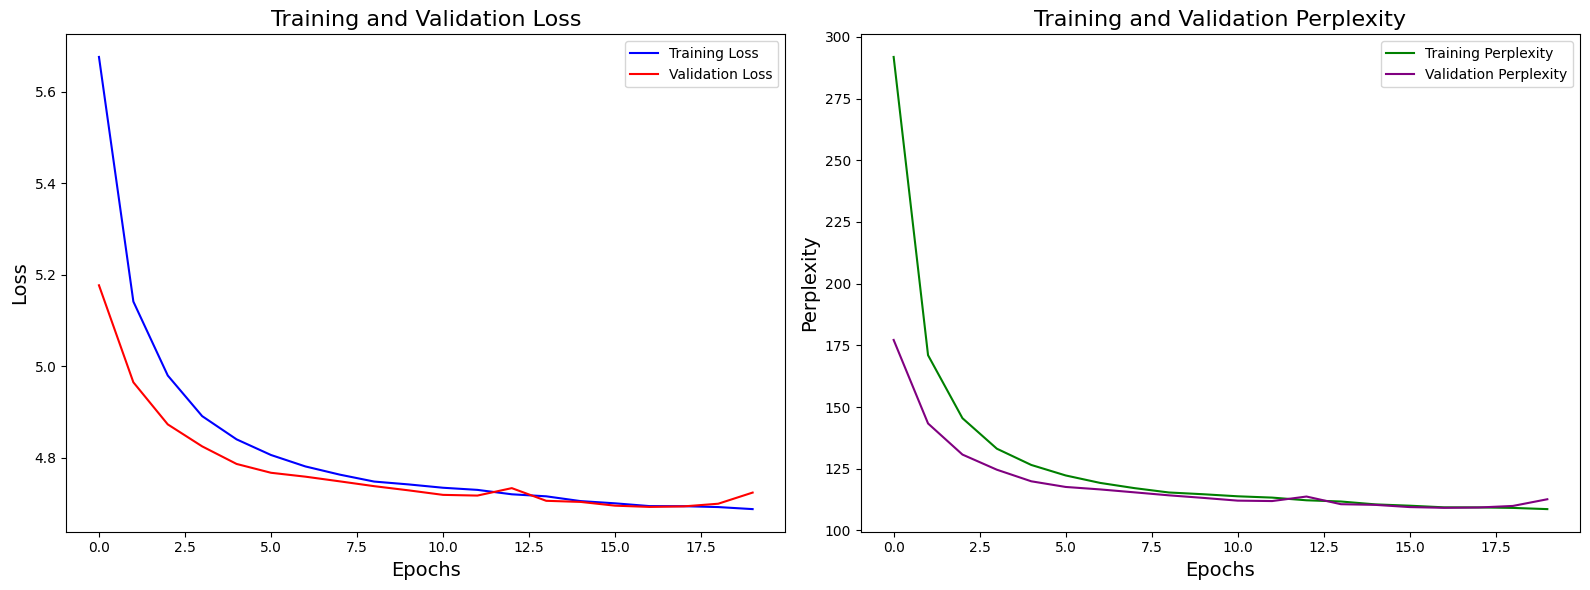

Test Perplexity: 105.078


(4.654707489411036, tensor(105.0785))

In [31]:
params = {
    'batch_size': 1024,
    'time_step': 30,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 2,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'weight_decay': 0.0001,
    'clip_value': 5,
    'predict_next_token_after_seq': True
}
model = RNNModel(params).to(device)
model.train()
model.test()

### With dropout
rnn_layers=2, dropout=0.3

2039 213 240
Epoch 1/20, Train Loss: 5.7520, Train Perplexity: 314.8112, Validation Loss: 5.2476, Validation Perplexity: 190.1096
Epoch 2/20, Train Loss: 5.2207, Train Perplexity: 185.0714, Validation Loss: 5.0398, Validation Perplexity: 154.4445
Epoch 3/20, Train Loss: 5.0690, Train Perplexity: 159.0188, Validation Loss: 4.9652, Validation Perplexity: 143.3419
Epoch 4/20, Train Loss: 4.9955, Train Perplexity: 147.7429, Validation Loss: 4.9329, Validation Perplexity: 138.7764
Epoch 5/20, Train Loss: 4.9567, Train Perplexity: 142.1202, Validation Loss: 4.8900, Validation Perplexity: 132.9505
Epoch 6/20, Train Loss: 4.9278, Train Perplexity: 138.0760, Validation Loss: 4.8741, Validation Perplexity: 130.8504
Epoch 7/20, Train Loss: 4.9048, Train Perplexity: 134.9326, Validation Loss: 4.8562, Validation Perplexity: 128.5373
Epoch 8/20, Train Loss: 4.8895, Train Perplexity: 132.8909, Validation Loss: 4.8541, Validation Perplexity: 128.2599
Epoch 9/20, Train Loss: 4.8768, Train Perplexity: 1

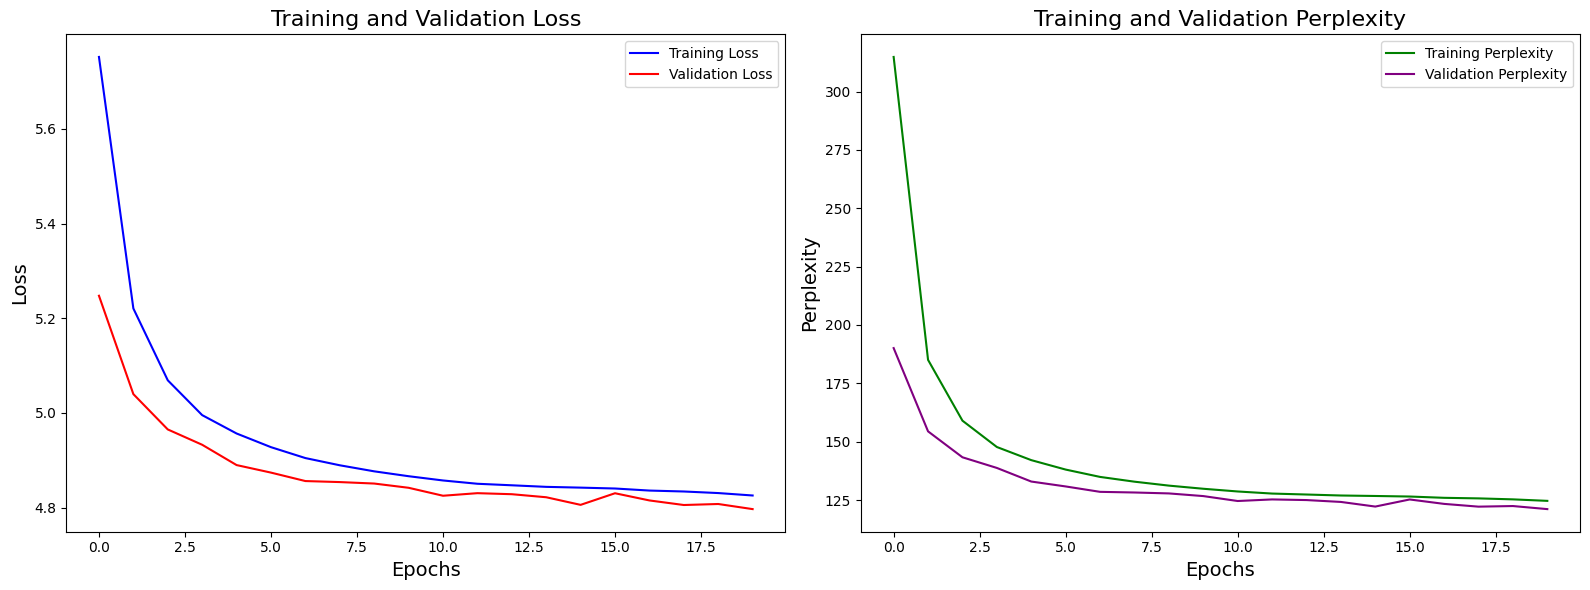

Test Perplexity: 112.672


(4.724478738506635, tensor(112.6718))

In [33]:
params = {
    'batch_size': 1024,
    'time_step': 30,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 2,
    'dropout': 0.3,
    'epoch': 20,
    'learning_rate': 0.001,
    'weight_decay': 0.0001,
    'clip_value': 5,
    'predict_next_token_after_seq': True
}
model = RNNModel(params).to(device)
model.train()
model.test()

**Conclusion**

Adding more RNN layers (making the network deeper) can help capture more complex features and relationships in the data due to the increased representational power. Layers=2 increases our performance and is suitable for our problem.

## 4. LSTM

By switching from RNN to LSTM, the model can potentially capture longer dependencies and mitigate issues like vanishing gradients. This could lead to improved performance, especially on tasks requiring understanding of long-term context.

In [34]:
class LSTMModel(nn.Module):
    def __init__(self, params):
        super(LSTMModel, self).__init__()
        self.params = params

        self.train_loader, self.valid_loader, self.test_loader, self.token_to_id = load_data(self.params)
        print (len(self.train_loader), len(self.valid_loader), len(self.test_loader))

        self.embedding = nn.Embedding(len(self.token_to_id), self.params['embedding_dim'])  # random initialize
        self.h = self._init_hidden(self.params['batch_size'])
        self.rnn = nn.LSTM(self.params['embedding_dim'], self.params['hidden_dim'], self.params['num_rnn_layer'], dropout=self.params['dropout'], batch_first=True)
        self.fc = nn.Linear(self.params['hidden_dim'], len(self.token_to_id))

        self.criterion = nn.CrossEntropyLoss()
        if self.params['weight_decay']:
          self.optimizer = optim.Adam(self.parameters(), lr=self.params['learning_rate'], weight_decay=self.params['weight_decay'])
        else:
          self.optimizer = optim.Adam(self.parameters(), lr=self.params['learning_rate'])

    def _init_hidden(self, batch_size):
        # Initialize both the hidden and cell states
        return (torch.zeros(self.params['num_rnn_layer'], batch_size, self.params['hidden_dim']).to(device),
            torch.zeros(self.params['num_rnn_layer'], batch_size, self.params['hidden_dim']).to(device))

    def forward(self, x, hidden):
        x = self.embedding(x)  # The embedding layer translates these indices into dense vectors of fixed size (the embedding size).
        x, (hidden, cell) = self.rnn(x, hidden)
        if self.params['predict_next_token_after_seq']:
          x = x[:, -1, :]   # Select only the outputs from the last timestep of each sequence; we do not need this sentence if we predict the next token after each token within a sequence.
        x = x.contiguous().view(-1, self.params['hidden_dim'])  # Reshape output for the fully connected layer
        out = self.fc(x)
        return out, (hidden, cell)

    def train(self):
        train_losses = []
        validation_losses = []
        train_perplexities = []
        validation_perplexities = []

        for epoch in range(self.params['epoch']):
            # Train
            train_loss = 0
            for id, (inputs, labels) in enumerate(self.train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()
                if self.params['training_shuffle']:
                    hidden = self._init_hidden(inputs.size(0))
                else:
                    hidden = (self.h[0].detach(), self.h[1].detach())
                outputs, self.h = self.forward(inputs, hidden)
                loss = self.criterion(outputs, labels.view(-1))
                loss.backward()
                if self.params['clip_value']:
                  torch.nn.utils.clip_grad_norm_(self.parameters(), self.params['clip_value'])
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(self.train_loader)
            train_losses.append(train_loss)
            train_perplexity = torch.exp(torch.tensor(train_loss)).item()
            train_perplexities.append(train_perplexity)
            print (f'Epoch {epoch + 1}/{self.params["epoch"]}, Train Loss: {train_loss:.4f}, Train Perplexity: {train_perplexity:.4f}')

            # Validation
            validation_loss = 0
            with torch.no_grad():
                for id, (inputs, labels) in enumerate(self.valid_loader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    hidden = self._init_hidden(inputs.size(0))
                    outputs, _ = self.forward(inputs, hidden)
                    loss = self.criterion(outputs, labels.view(-1))
                    validation_loss += loss.item()
            validation_loss /= len(self.valid_loader)
            validation_losses.append(validation_loss)
            validation_perplexity = torch.exp(torch.tensor(validation_loss)).item()
            validation_perplexities.append(validation_perplexity)
            print (f'Epoch {epoch + 1}/{self.params["epoch"]}, Validation Loss: {validation_loss:.4f}, Validation Perplexity: {validation_perplexity:.4f}')

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        # Plotting Training and Validation Loss on the first subplot
        ax1.plot(train_losses, label='Training Loss', color='blue')
        ax1.plot(validation_losses, label='Validation Loss', color='red')
        ax1.set_title('Training and Validation Loss', fontsize=16)
        ax1.set_xlabel('Epochs', fontsize=14)
        ax1.set_ylabel('Loss', fontsize=14)
        ax1.legend()
        # Plotting Training and Validation Perplexity on the second subplot
        ax2.plot(train_perplexities, label='Training Perplexity', color='green')
        ax2.plot(validation_perplexities, label='Validation Perplexity', color='purple')
        ax2.set_title('Training and Validation Perplexity', fontsize=16)
        ax2.set_xlabel('Epochs', fontsize=14)
        ax2.set_ylabel('Perplexity', fontsize=14)
        ax2.legend()
        # Display the plots
        plt.tight_layout()
        # fig_name = '_'.join([str(item) for item in self.params.values()]) + '.jpg'
        # plt.savefig(fig_name, dpi=300, bbox_inches='tight')
        plt.show()

    def test(self):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                hidden = self._init_hidden(inputs.size(0))
                outputs, _ = self.forward(inputs, hidden)
                loss = self.criterion(outputs, labels.view(-1))
                total_loss += loss.item()
        avg_loss = total_loss / len(self.test_loader)
        perplexity = torch.exp(torch.tensor(avg_loss))
        print(f'Test Perplexity: {perplexity.item():.3f}')
        return avg_loss, perplexity

2039 213 240
Epoch 1/20, Train Loss: 5.9666, Train Perplexity: 390.1961
Epoch 1/20, Validation Loss: 5.4591, Validation Perplexity: 234.8901
Epoch 2/20, Train Loss: 5.4357, Train Perplexity: 229.4640
Epoch 2/20, Validation Loss: 5.2261, Validation Perplexity: 186.0742
Epoch 3/20, Train Loss: 5.2777, Train Perplexity: 195.9089
Epoch 3/20, Validation Loss: 5.1280, Validation Perplexity: 168.6865
Epoch 4/20, Train Loss: 5.2100, Train Perplexity: 183.1003
Epoch 4/20, Validation Loss: 5.0974, Validation Perplexity: 163.5885
Epoch 5/20, Train Loss: 5.1690, Train Perplexity: 175.7336
Epoch 5/20, Validation Loss: 5.0614, Validation Perplexity: 157.8053
Epoch 6/20, Train Loss: 5.1333, Train Perplexity: 169.5737
Epoch 6/20, Validation Loss: 5.0288, Validation Perplexity: 152.7541
Epoch 7/20, Train Loss: 5.0993, Train Perplexity: 163.9077
Epoch 7/20, Validation Loss: 5.0044, Validation Perplexity: 149.0672
Epoch 8/20, Train Loss: 5.0759, Train Perplexity: 160.1195
Epoch 8/20, Validation Loss: 4.9

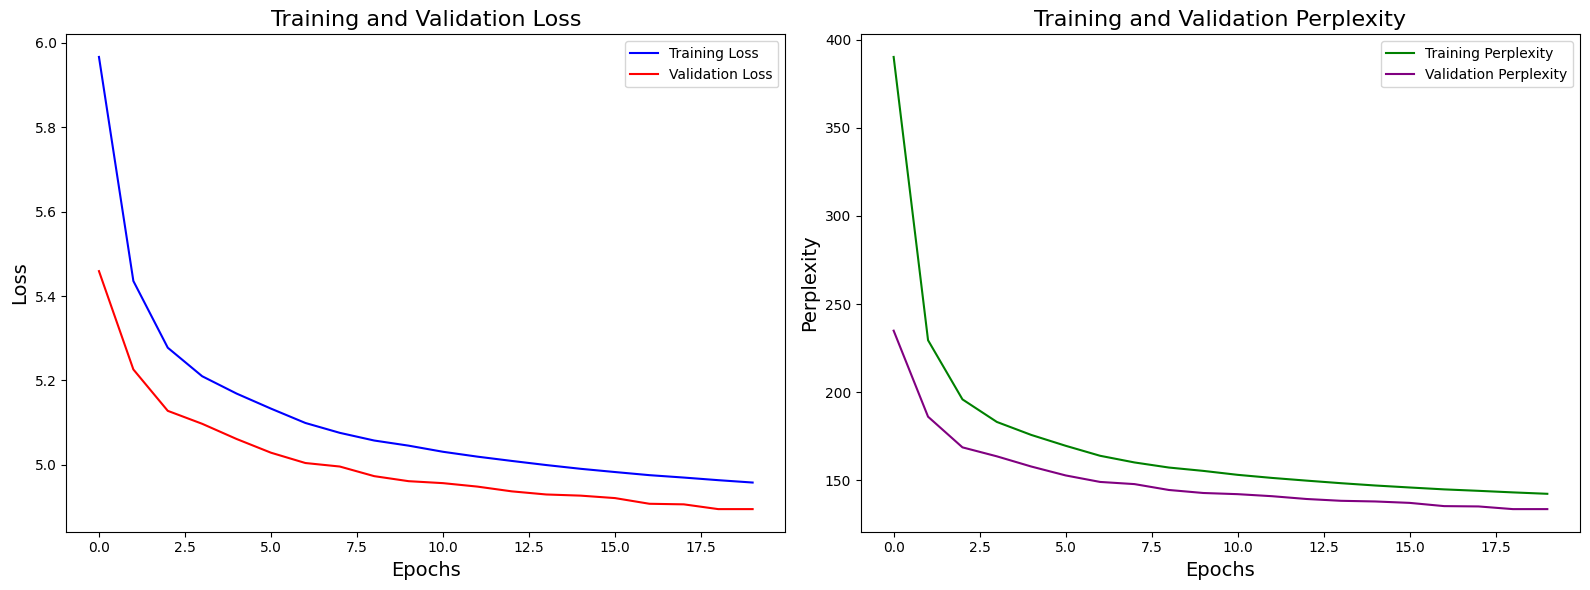

Test Perplexity: 125.163


(4.829613749186198, tensor(125.1626))

In [35]:
params = {
    'batch_size': 1024,
    'time_step': 30,
    'embedding_dim': 100,
    'hidden_dim': 100,
    'num_rnn_layer': 2,
    'dropout': 0,
    'epoch': 20,
    'learning_rate': 0.001,
    'training_shuffle': True,
    'weight_decay': 0.0001,
    'clip_value': 5,
    'predict_next_token_after_seq': True
}
model = LSTMModel(params).to(device)
model.train()
model.test()

Compared with the RNN model with the same hyper parameters, there is no significant increase in the perplexity.

The reasons might be as follows:

1. If the task is relatively simple or the sequences are short, the advantages of LSTMs may not come into play, and the simpler RNN might perform adequately or even better due to fewer parameters and less overfitting.
2. For datasets where long-term dependencies are less important, or contexts are short enough, LSTMs may not show significant improvement over RNNs.
3. LSTMs may require more epochs to converge due to their complexity. If training is halted too soon (20 epochs), the LSTM might not reach its full potential.

## Conclusion
By incorporating weight decay to address overfitting and utilizing two RNN layers without dropout, we successfully reduced the perplexity from 109 to 105.

However, switching to LSTM with the current hyperparameters did not yield any improvement. For better results, further experiments should be conducted with more parameters or by adding attention layers.